In [79]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory

import matplotlib.pyplot as plt

In [80]:
print(tf.__version__)
print(tf.config.list_physical_devices())

2.18.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [81]:
IMG_SIZE = 150

model = tfk.Sequential([
    tfkl.Conv2D(32, kernel_size=3, strides=1, kernel_regularizer=l2(0.0001), input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    tfkl.BatchNormalization(),
    tfkl.ReLU(),
    tfkl.MaxPool2D(),
    tfkl.Conv2D(128, kernel_size=3, strides=1, kernel_regularizer=l2(0.0001)),
    tfkl.BatchNormalization(),
    tfkl.ReLU(),
    tfkl.MaxPool2D(),
    tfkl.Conv2D(256, kernel_size=3, strides=1),
    tfkl.BatchNormalization(),
    tfkl.ReLU(),
    tfkl.MaxPool2D(),
    tfkl.Flatten(),
    tfkl.Dense(128),
    tfkl.BatchNormalization(),
    tfkl.ReLU(),
    tfkl.Dropout(0.5),
    tfkl.Dense(256),
    tfkl.BatchNormalization(),
    tfkl.ReLU(),
    tfkl.Dense(1, activation="sigmoid")
])

In [82]:
DATASET_PATH = "/kaggle/input/nih-malaria-dataset/cell_images"

TRAIN_SIZE = 0.80
VAL_SIZE = 1.0 - TRAIN_SIZE
# VAL_SIZE = 1.0 - TRAIN_SIZE - TEST_SIZE

datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=50,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=VAL_SIZE
)

train_gen = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="rgb",
    class_mode="binary",
    seed=22,
    shuffle=True,
    subset="training"
)

val_gen = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="rgb",
    class_mode="binary",
    seed=22,
    shuffle=True,
    subset="validation"
)


Found 22048 images belonging to 2 classes.
Found 5510 images belonging to 2 classes.


A. Uninfected: 11024 samples
B. Parasitized: 11024 samples


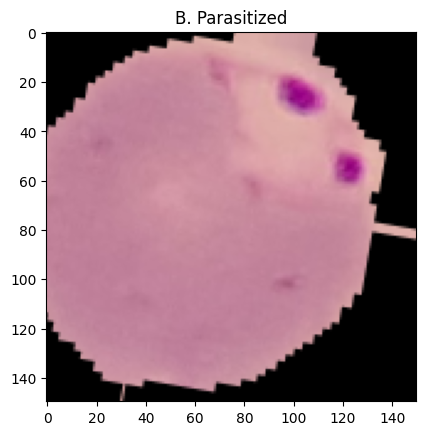

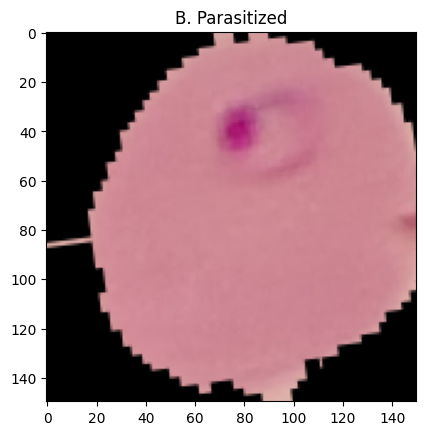

In [83]:
# printing class distribution
class_indices = train_gen.class_indices  
class_names = list(class_indices.keys())
num_classes = len(class_names)
class_counts = np.zeros(num_classes, dtype=int)

for i in range(len(train_gen.classes)):
    class_counts[int(train_gen.classes[i])] += 1

for i, class_name in enumerate(class_names):
    print(f"{class_name}: {class_counts[i]} samples")
    
# visualise one image
for img, lab in train_gen:
    plt.imshow(img[0])
    plt.title(f"{class_names[int(lab[0])]}")
    plt.show()
    break

for img, lab in val_gen:
    plt.imshow(img[0])
    plt.title(f"{class_names[int(lab[0])]}")
    plt.show()
    break


Model compilation definitions...

In [84]:
n_epochs = 40

model_callbacks = [
    tfk.callbacks.ReduceLROnPlateau(patience=3, factor=0.5, verbose=1, min_lr=1e-10), 
    tfk.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=9,verbose=1,mode="auto"
)]

model.compile(
    optimizer=tfk.optimizers.Adam(learning_rate=1e-3),
    loss=tfk.losses.BinaryCrossentropy(),
    metrics=[tfk.metrics.BinaryAccuracy()],
)


In [85]:
print(model.summary())

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)                   │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_50               │ (None, 148, 148, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_50 (ReLU)                      │ (None, 148, 148, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 72, 72, 128)         │          36,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_51               │ (None, 72, 72, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_51 (ReLU)                      │ (None, 72, 72, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_31 (MaxPooling2D)      │ (None, 36, 36, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 34, 34, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_52               │ (None, 34, 34, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_52 (ReLU)                      │ (None, 34, 34, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_32 (MaxPooling2D)      │ (None, 17, 17, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_14 (Flatten)                 │ (None, 73984)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 128)                 │       9,470,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_53               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_53 (ReLU)                      │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_54               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │              

 Total params: 9,839,617 (37.54 MB)

 Trainable params: 9,838,017 (37.53 MB)

 Non-trainable params: 1,600 (6.25 KB)

None


In [86]:
model.fit(train_gen, validation_data=val_gen, epochs=n_epochs, callbacks=model_callbacks)

Epoch 1/40
689/689 ━━━━━━━━━━━━━━━━━━━━ 194s 271ms/step - binary_accuracy: 0.8128 - loss: 0.4235 - val_binary_accuracy: 0.9318 - val_loss: 0.2775 - learning_rate: 0.0010
Epoch 2/40
689/689 ━━━━━━━━━━━━━━━━━━━━ 186s 270ms/step - binary_accuracy: 0.9369 - loss: 0.2056 - val_binary_accuracy: 0.9069 - val_loss: 0.2824 - learning_rate: 0.0010
Epoch 3/40
689/689 ━━━━━━━━━━━━━━━━━━━━ 166s 241ms/step - binary_accuracy: 0.9435 - loss: 0.1848 - val_binary_accuracy: 0.9309 - val_loss: 0.1841 - learning_rate: 0.0010
Epoch 4/40
689/689 ━━━━━━━━━━━━━━━━━━━━ 161s 234ms/step - binary_accuracy: 0.9446 - loss: 0.1763 - val_binary_accuracy: 0.9312 - val_loss: 0.2028 - learning_rate: 0.0010
Epoch 5/40
689/689 ━━━━━━━━━━━━━━━━━━━━ 167s 242ms/step - binary_accuracy: 0.9489 - loss: 0.1681 - val_binary_accuracy: 0.9240 - val_loss: 0.2379 - learning_rate: 0.0010
Epoch 6/40
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - binary_accuracy: 0.9494 - loss: 0.1572
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.

In [88]:
model.save("malaria_classifier.keras")